In [64]:
import sys
module_root = '..'
if module_root not in sys.path:
  sys.path.insert(0, module_root)
import os
graphviz_bin_dir = f'{os.environ["HOME"]}/.nix-profile/bin/'
if graphviz_bin_dir not in os.environ['PATH'].split(os.pathsep):
  os.environ['PATH'] += os.pathsep + graphviz_bin_dir
from numpy import r_, zeros_like, atleast_2d
from typing import List

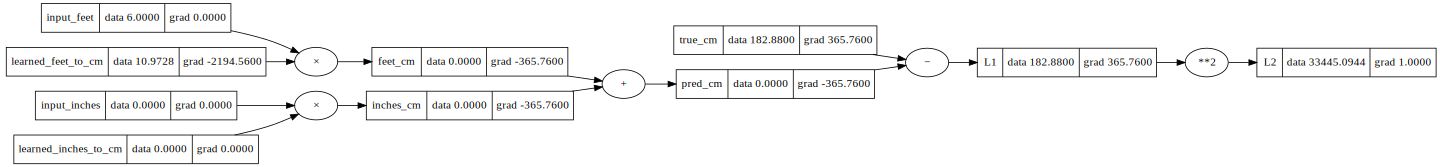

In [73]:
from importlib import reload
import minigrad.tensor as mg_tensor
reload(mg_tensor)
from minigrad.tensor import BadTensor

import minigrad.graph as mg_graph
reload(mg_graph)
from minigrad.graph import draw_dot

from graphviz import Digraph

def feet_inches() -> Digraph:
  lr = 5e-3
  feet = BadTensor(r_[6.], label='input_feet')
  inches = BadTensor(r_[0.], label='input_inches')
  # should converge on 2.54*12
  feet_to_cm = BadTensor(r_[0.], label='learned_feet_to_cm', train_me=True)
  # should converge on 2.54
  inches_to_cm = BadTensor(r_[0.], label='learned_inches_to_cm', train_me=True)
  expected_cm = BadTensor(r_[182.88], label='true_cm')

  for _ in range(1):
    feet_cm = (feet * feet_to_cm).label_('feet_cm')
    inches_cm = (inches * inches_to_cm).label_('inches_cm')
    predicted_cm = (feet_cm + inches_cm).label_('pred_cm')
    L1 = (expected_cm - predicted_cm).label_('L1')
    L2 = (L1 ** 2).label_('L2')
    
    for t in L2.ancestors():
      t.grad = zeros_like(t.data)

    L2.backward()

    trainable: List[BadTensor] = [t for t in L2.ancestors() if t.train_me]
    for t in trainable:
      t.data -= t.grad * lr

  return draw_dot(L2)
feet_inches()

In [ ]:
def feet_inches_mat() -> Digraph:
  lr = 5e-3
  feet_inches = BadTensor(r_[6., 0.], label='input_feet_inches')
  # should converge on [[2.54*12], [2.54]]
  feet_inches_to_cm = BadTensor(atleast_2d([0., 0.]).T, label='learned_feet_inches_to_cm', train_me=True)
  expected_cm = BadTensor(r_[182.88], label='true_cm')

  for _ in range(10):
    predicted_cm = (feet_inches @ feet_inches_to_cm).label_('predicted_cm')
    L1 = (expected_cm - predicted_cm).label_('L1')
    L2 = (L1 ** 2).label_('L2')
    
    for t in L2.ancestors():
      t.grad = zeros_like(t.data)

    L2.backward()

    trainable: List[BadTensor] = [t for t in L2.ancestors() if t.train_me]
    for t in trainable:
      t.data -= t.grad * lr

  return draw_dot(L2)
feet_inches_mat()

In [68]:
r_[6., 0.] @ atleast_2d([2.54*12, 2.54]).T

array([182.88])

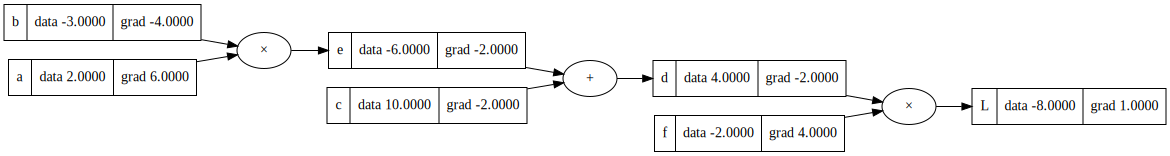

In [48]:
def karpathy_basic() -> Digraph:
  a = BadTensor(r_[2.], label='a')
  b = BadTensor(r_[-3.], label='b')
  c = BadTensor(r_[10.], label='c')
  f = BadTensor(r_[-2.], label='f')
  e = (a * b).label_('e')
  d = (c + e).label_('d')
  L = (d * f).label_('L')
  L.backward()
  return draw_dot(L)
karpathy_basic()

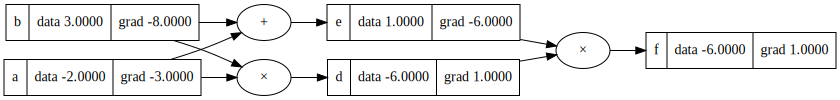

In [49]:
def karpathy_crossed() -> Digraph:
  a = BadTensor(r_[-2.], label='a')
  b = BadTensor(r_[3.], label='b')
  d = (a * b).label_('d')
  e = (a + b).label_('e')
  f = (d * e).label_('f')
  f.backward()
  return draw_dot(f)
karpathy_crossed()